# Machine Learning: Recurrent Neural Networks And Long Short Term Memory (LSTM)

Recurrent neural networks have a wide array of applications. These include time series analysis, document classification, speech and voice recognition. In contrast to feedforward artificial neural networks, the predictions made by recurrent neural networks are dependent on previous predictions.

To elaborate, imagine we decided to follow an exercise routine where, every day, we alternate between lifting weights, swimming and yoga. We could then build a recurrent neural network to predict today’s workout given what we did yesterday. For example, if we lifted weights yesterday then we’d go swimming today.

More often than not, the problems you’ll be tackling in the real world will be a function of the current state as well as other inputs. For instance, suppose we signed up for hockey once a week. If we’re playing hockey on the same day that we’re supposed to lift weights then we might decide to skip the gym. Thus, our model now has to differentiate between the case when we attended a yoga class yesterday and we’re not playing hockey as well as the case when we attended a yoga class yesterday and we’re playing hockey today in which case we’d jump directly to swimming.

## Long Short Term Memory (LSTM)

In practice, we rarely see regular recurrent neural networks being used. Recurrent neural networks have a few shortcomings which render them impractical. For instance, say we added in a rest day. The rest day should only be taken after two days of exercise. In the event we use a recurrent neural network to try and predict what activity we’ll do tomorrow, it’s possible that it gets trapped in a loop.

Suppose we had the following scenario.

    Day 1: Lift Weights
    Day 2: Swimming
    Day 3: At this point, our model must decide whether we should take a rest day or yoga. Unfortunately, it only has access to the previous day. In other words, it knows we swam yesterday but it doesn’t know whether had taken a break the day before.Therefore, it can end up predicting yoga.

LSTMs were invented, to get around this problem. As the name implies LSTMs have memory. Just like how humans can store roughly 7 bits of information in short term memory, LSTMs can in theory remember information going back several states. However, this raises the question as to how far back they should remember. At what point does information become irrelevant? For instance, in our exercise example, we shouldn’t need to go back more than two days to figure out whether we should take a break.

Without delving into too much detail, LSTMs combat this problem by using dedicated neural networks for forgetting and selecting information. A single LTSM layer is composed of four neural network layers interacting in a special way.

![alt text](./images/1.png)

One of the tricky things about natural language processing is that the meaning of words can change depending on their context. In the case of sentiment analysis, we can’t just go off the occurrences of some words like good because its meaning changes completely if it’s preceded by the word not as in not good. It’s also extremely difficult for computers to recognize things like sarcasm since they require reading in between the lines. LSTM networks turn out to be particularly well suited for solving these kinds of problems since they can remember all the words that led up to the one in question.

In the proceeding section, we go over my solution to a Kaggle competition whose goal it is to perform sentiment analysis on a corpus of movie reviews. We’re asked to label each phrase on a scale of zero to four. The sentiment corresponding to each of the labels are:

    0: negative
    1: somewhat negative
    2: neutral
    3: somewhat positive
    4: positive

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('train.tsv', sep='\t')

print('train set: {0}'.format(df_train.shape))
df_train.head(10)

train set: (156060, 4)


PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   
5         6           1  of escapades demonstrating the adage that what...   
6         7           1                                                 of   
7         8           1  escapades demonstrating the adage that what is...   
8         9           1                                          escapades   
9        10           1  demonstrating the adage that what is good for ...   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  
5          2  
6          2  
7          2  
8          2  
9          2

In [3]:
df_test = pd.read_csv('test.tsv', sep='\t')

print('test set: {0}'.format(df_test.shape))
df_test.head(10)

test set: (66292, 3)


PhraseId  SentenceId                                             Phrase
0    156061        8545  An intermittently pleasing but mostly routine ...
1    156062        8545  An intermittently pleasing but mostly routine ...
2    156063        8545                                                 An
3    156064        8545  intermittently pleasing but mostly routine effort
4    156065        8545         intermittently pleasing but mostly routine
5    156066        8545                        intermittently pleasing but
6    156067        8545                            intermittently pleasing
7    156068        8545                                     intermittently
8    156069        8545                                           pleasing
9    156070        8545                                                but

ASCII characters are ultimately interpreted by the computer as hexadecimal. In consequence, to a computer, ‘A’ is not the same as ‘a’. Therefore, we’ll want to change all characters to lowercase. Since we’re going to be splitting the sentences up into individual words based off of white spaces, a word with a period right after it is not equivalent to one without a period following it (happy. != happy). In addition, contractions are going to be interpreted differently than the original which will have repercussions for the model (I’m != I am). Thus, we replace all occurrences using the proceeding function.

In [4]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [5]:
X_train = df_train['Phrase'].apply(lambda p: clean_text(p))

max phrase len: 53


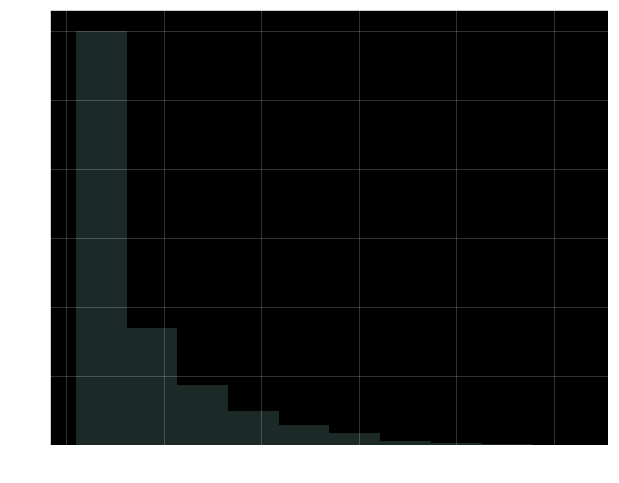

In [6]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))

plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [7]:
batch_size = 512
epochs = 8
num_classes = 5
max_words = 8192

In [8]:
y_train = df_train['Sentiment']

Computers don’t understand words, let alone sentences, therefore, we use the tokenizer to parse the phrases. In specifying num_words, only the most common num_words-1 words will be kept. We use a filter to remove special characters. By default, all punctuation is removed, turning the text into a space separated sequence of words. The tokens are then vectorized. By vectorized we mean that they are mapped to integers. 0 is a reserved index that won't be assigned to any word.

pad_sequence is used to ensure that all the phrase are the same length. Sequences that are shorter than maxlen are padded with value (0 by default) at the end.

Whenever we’re working with categorical data, we don’t want to leave it as integers because the model will interpreted the samples with a higher number as having more significance. to_categorical is quick and dirty way of encoding the data.

In [9]:
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

In [10]:
model_lstm = Sequential()

model_lstm.add(Embedding(input_dim = max_words, output_dim = 256, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(num_classes, activation = 'softmax'))

model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [11]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 512
)

Train on 140454 samples, validate on 15606 samples
Epoch 1/8
140454/140454 [==============================] - 150s 1ms/step - loss: 1.0596 - acc: 0.5774 - val_loss: 1.0159 - val_acc: 0.5862
Epoch 2/8
140454/140454 [==============================] - 147s 1ms/step - loss: 0.8555 - acc: 0.6565 - val_loss: 1.0023 - val_acc: 0.6038
Epoch 3/8
140454/140454 [==============================] - 146s 1ms/step - loss: 0.8039 - acc: 0.6759 - val_loss: 1.0092 - val_acc: 0.6053
Epoch 4/8
140454/140454 [==============================] - 146s 1ms/step - loss: 0.7710 - acc: 0.6871 - val_loss: 1.0081 - val_acc: 0.6054
Epoch 5/8
140454/140454 [==============================] - 147s 1ms/step - loss: 0.7456 - acc: 0.6957 - val_loss: 1.0385 - val_acc: 0.6046
Epoch 6/8
140454/140454 [==============================] - 147s 1ms/step - loss: 0.7232 - acc: 0.7047 - val_loss: 1.0476 - val_acc: 0.6059
Epoch 7/8
140454/140454 [==============================] - 146s 1ms/step - loss: 0.7055 - acc: 0.7110 - val_loss: 1

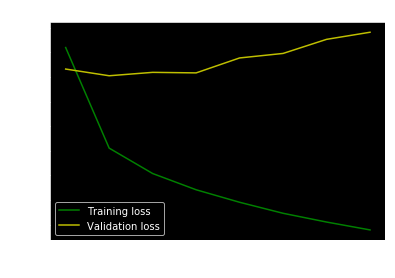

In [12]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

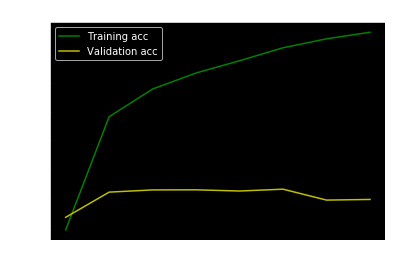

In [13]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Final Thoughts

Recurrent neural networks can be used to model any phenomenon that is dependent on its preceding state. The example, we covered in this article is that of semantics. In other words, the meaning of a sentence changes as it progresses. Rather than attempting to classify documents based off the occurrence of some word (i.e. good), we can use a more sophisticated approach to capture the interplay between words (i.e. movie was not good).